# Channel Flow (Steady) DEMO code

This notebook demonstrates solving steady-state Flow around cylinder with the same setup as this paper https://arxiv.org/abs/2002.10558

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain: a rectangle with a circular obstacle (cylinder). This defines the area for simulation.

In [2]:
circle = df.geometry.circle(0.2, 0.2, 0.05)
rectangle = df.geometry.rectangle([0,1.1], [0,0.41])
area = rectangle - circle

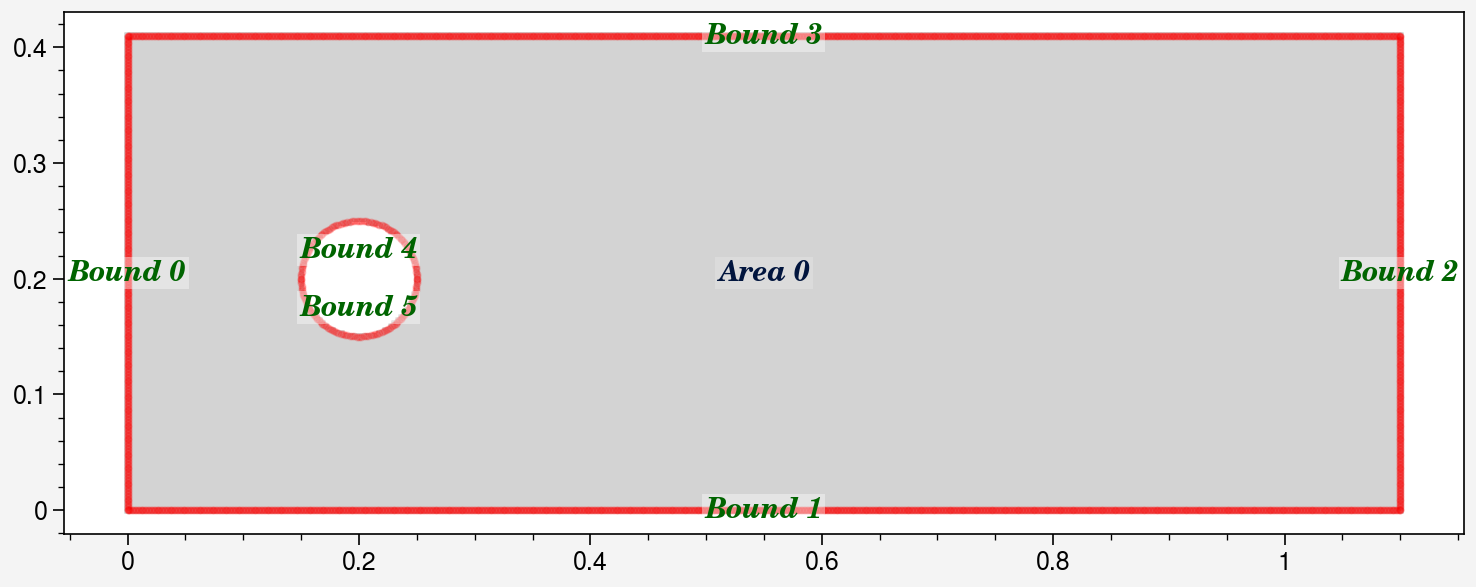

In [3]:
domain = df.domain(area, circle.bound_list)
domain.show_setup()

## 2. Define Physics
Define the Navier-Stokes equations for fluid flow and apply boundary conditions (e.g., no-slip walls, inlet velocity).

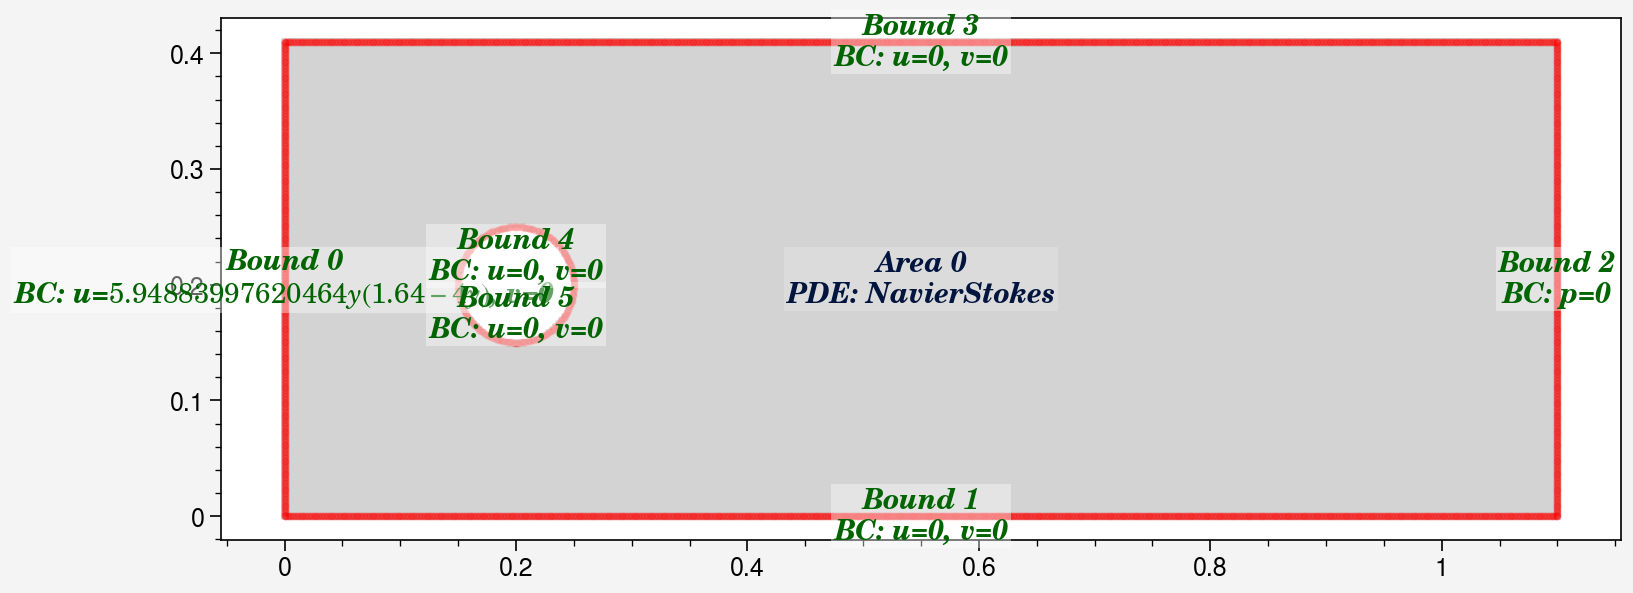

In [4]:
domain.bound_list[0].define_bc({'u': ['y', lambda x:  4*1*(0.41-x)*x/0.41**2], 'v': 0})
domain.bound_list[1].define_bc({'u': 0,'v': 0})
domain.bound_list[2].define_bc({'p': 0})
domain.bound_list[3].define_bc({'u': 0,'v': 0})
domain.bound_list[4].define_bc({'u': 0, 'v': 0})
domain.bound_list[5].define_bc({'u': 0, 'v': 0})
domain.area_list[0].define_pde(df.NavierStokes(U=1, L=1, mu=0.02, rho=1))
domain.show_setup()


Sample initial points for training.

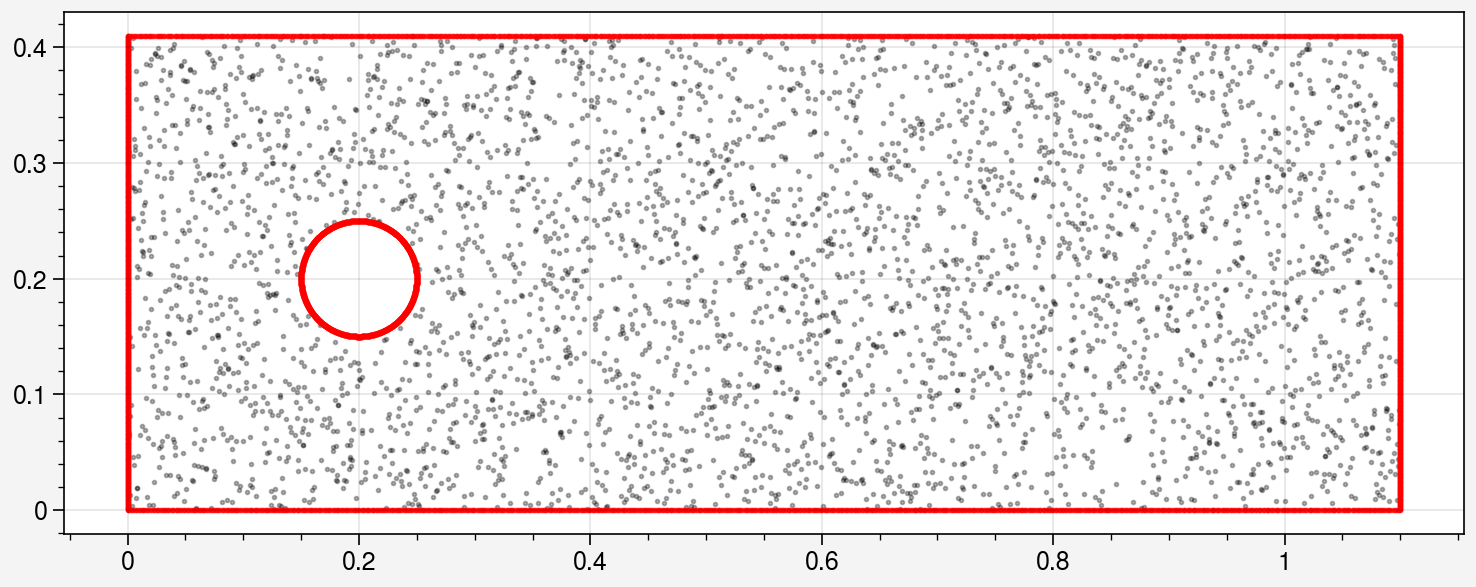

In [5]:
domain.sampling_lhs(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[4000])
domain.show_coordinates(display_physics=False)

## 3. Train the PINN model

Define how collocation points are sampled during training.

In [ ]:
def do_in_adam(epoch, model):
    return
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3(bound_sampling_res=[1000, 1000, 1000, 1000, 1000, 1000], area_sampling_res=[4000])
        print(domain)

Train the model using Adam for initial training (faster convergence).

In [ ]:
model0 = df.PINN(width=50, length=5, input_vars=['x','y'], output_vars=['u','v','p'])

# Train the model
model1, model1best = model0.train_adam(
    learning_rate=0.004,
    epochs=2000,
    calc_loss=df.calc_loss_simple(domain),
    threshold_loss=0.01,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.73840, bc_loss: 0.73788, pde_loss: 0.00053
Epoch: 200, total_loss: 0.22851, bc_loss: 0.20319, pde_loss: 0.02532
Epoch: 400, total_loss: 0.20562, bc_loss: 0.17889, pde_loss: 0.02673
Epoch: 600, total_loss: 0.19221, bc_loss: 0.16597, pde_loss: 0.02624
Epoch: 800, total_loss: 0.18192, bc_loss: 0.16069, pde_loss: 0.02123
Epoch: 1000, total_loss: 0.17445, bc_loss: 0.14232, pde_loss: 0.03212
Epoch: 1200, total_loss: 0.14289, bc_loss: 0.12102, pde_loss: 0.02187
Epoch: 1400, total_loss: 0.24062, bc_loss: 0.21394, pde_loss: 0.02669
Epoch: 1600, total_loss: 0.21580, bc_loss: 0.18649, pde_loss: 0.02930
Epoch: 1800, total_loss: 0.20538, bc_loss: 0.17723, pde_loss: 0.02815
Epoch: 2000, total_loss: 0.20238, bc_loss: 0.16498, pde_loss: 0.03740


Refine the model using LBFGS for higher precision.

In [8]:
# Train the model
model2 = model1best.train_lbfgs(
    calc_loss=df.calc_loss_simple(domain),
    epochs=450,
    threshold_loss=0.0001,
    do_between_epochs=do_in_lbfgs)

Epoch: 1248, total_loss: 0.13073, bc_loss: 0.10979, pde_loss: 0.02094
Epoch: 1298, total_loss: 0.02247, bc_loss: 0.01089, pde_loss: 0.01158
Epoch: 1348, total_loss: 0.00434, bc_loss: 0.00100, pde_loss: 0.00334
number of bound : ['0: 1437', '1: 1381', '2: 1398', '3: 1516', '4: 1517', '5: 1363']
number of area : ['0: 5332']
Epoch: 1398, total_loss: 0.00307, bc_loss: 0.00057, pde_loss: 0.00250
Epoch: 1448, total_loss: 0.00160, bc_loss: 0.00033, pde_loss: 0.00127
number of bound : ['0: 1807', '1: 1708', '2: 1987', '3: 1895', '4: 1936', '5: 1821']
number of area : ['0: 6368']
Epoch: 1498, total_loss: 0.00177, bc_loss: 0.00034, pde_loss: 0.00143
Epoch: 1548, total_loss: 0.00118, bc_loss: 0.00026, pde_loss: 0.00093
number of bound : ['0: 2158', '1: 1938', '2: 2504', '3: 2186', '4: 2344', '5: 2235']
number of area : ['0: 7266']
Training interrupted by user.


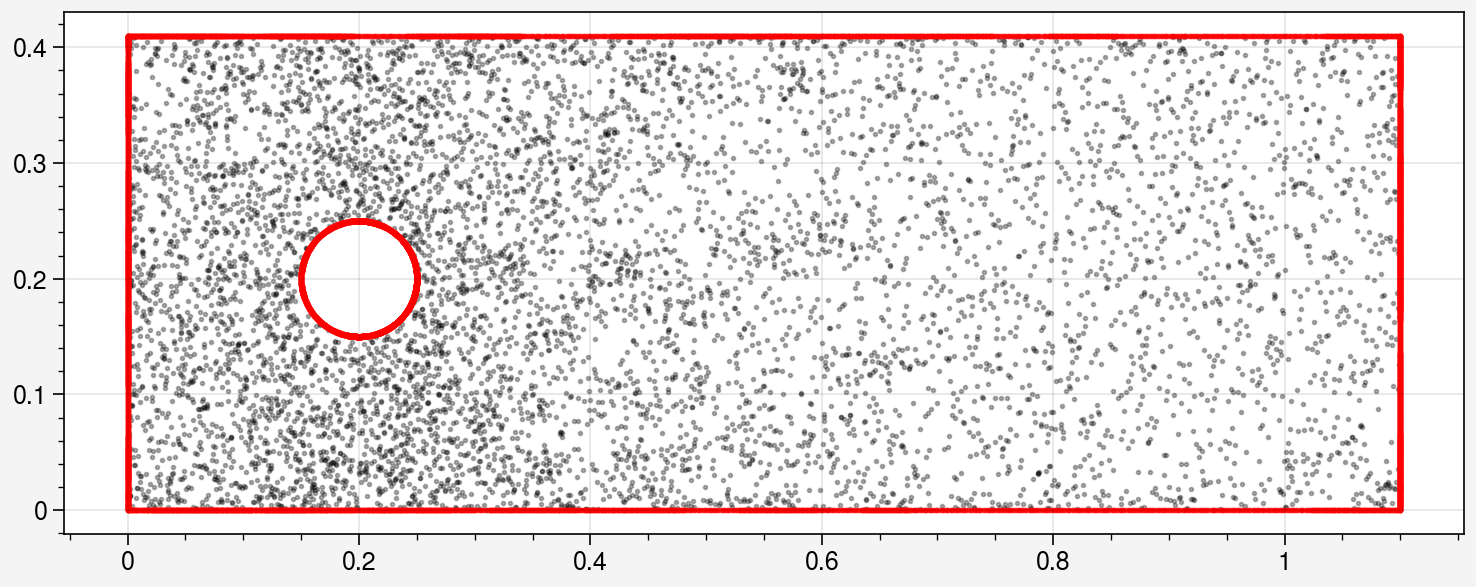

In [9]:
domain.show_coordinates()

Save or Load the model for later use

In [10]:
model2.save_as_pickle("model.pkl")
model2 = df.load_from_pickle("model.pkl")

## 4. Visualization

### 4.1 Visualize area

In [11]:
# Create object for evaluation
area_eval = domain.area_list[0].evaluate(model2)
# Sampling uniform points
area_eval.sampling_area([300, 150])
# Show available data's key
print(area_eval)

Available data keys: ('u', 'v', 'p', 'pde_residual', 'x', 'y', 'u_x', 'u_y', 'v_x', 'v_y', 'p_x', 'p_y', 'continuity_residual', 'x_momentum_residual', 'y_momentum_residual', 'total_loss', 'bc_loss', 'pde_loss')


C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  func(*args, **kwargs)


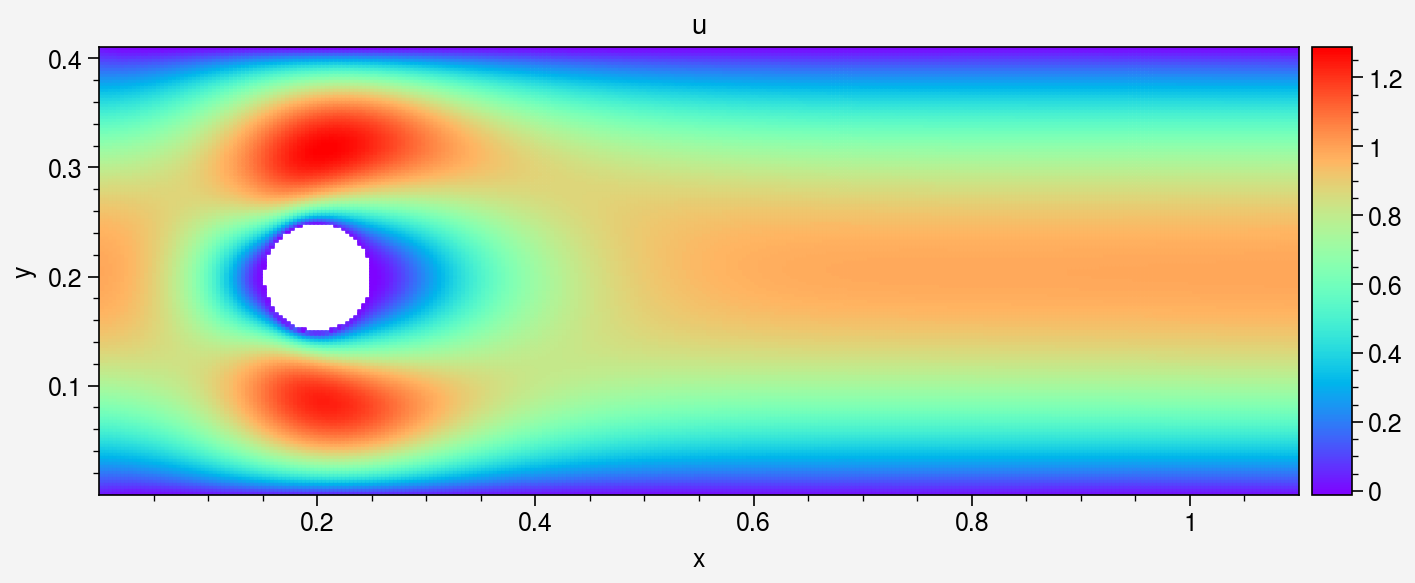

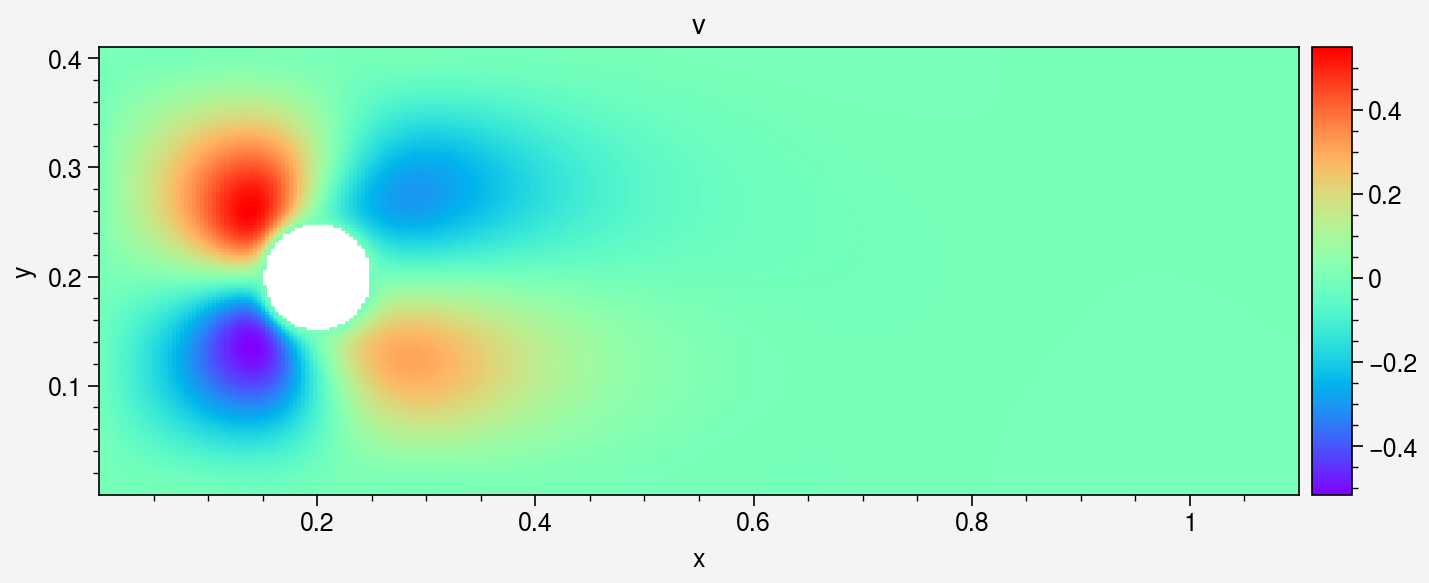

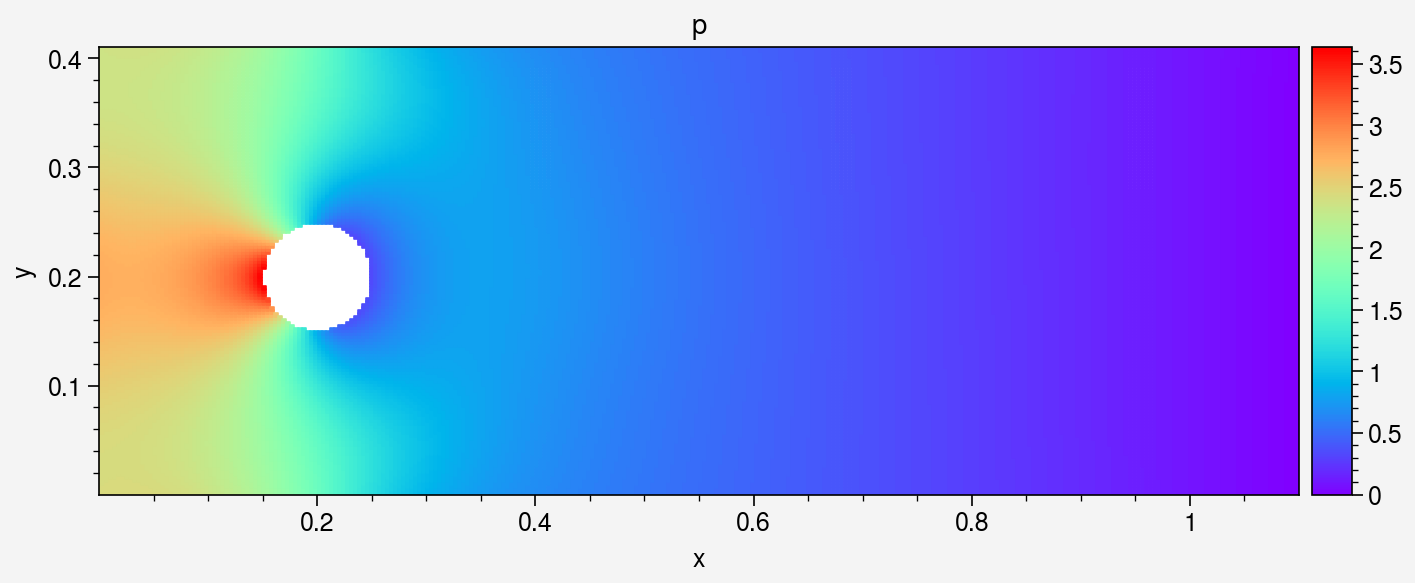

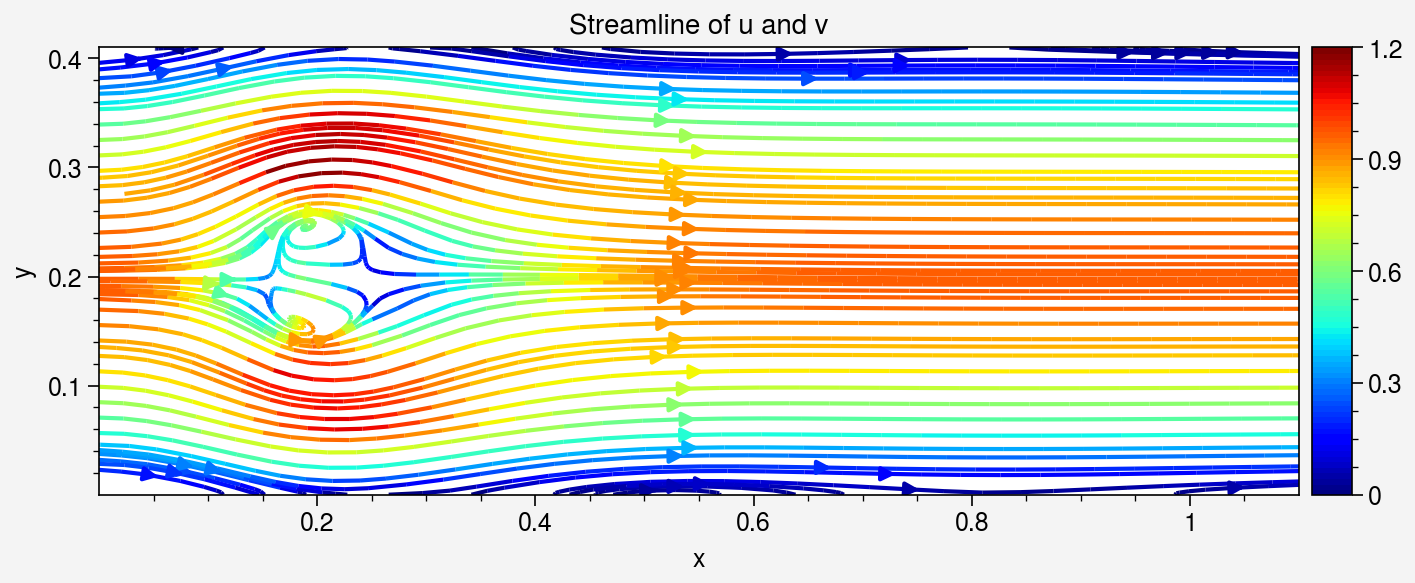

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  fig.canvas.print_figure(bytes_io, **kw)


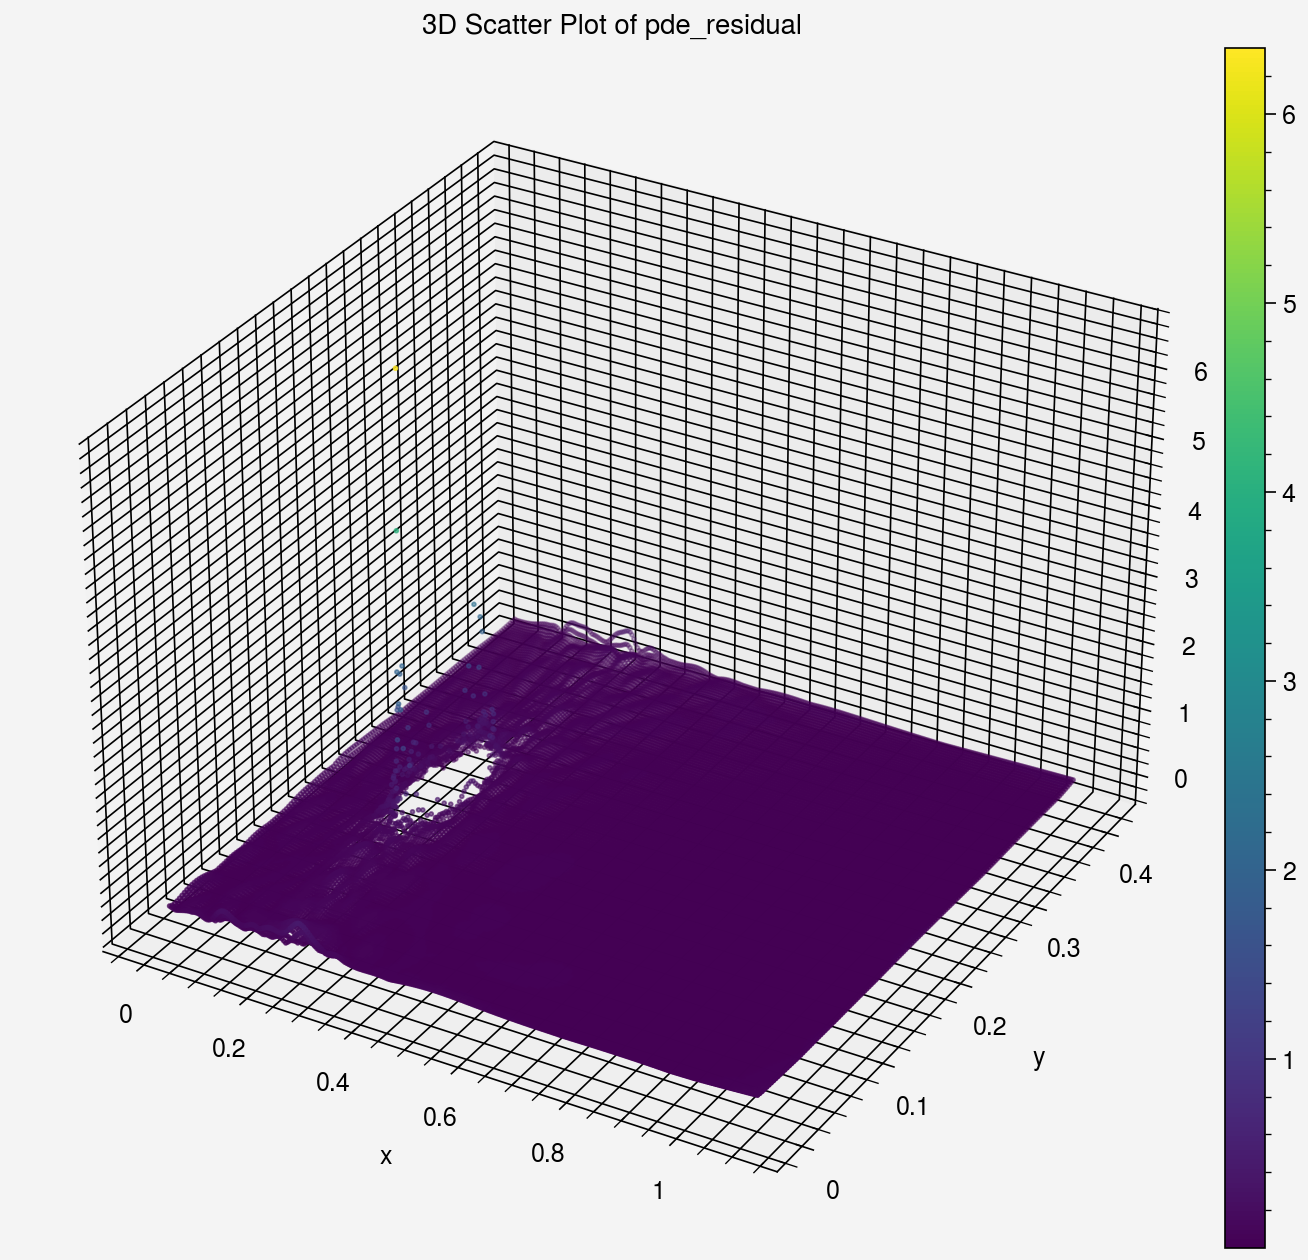

In [21]:
area_eval.plot_color('u', s=2, cmap='rainbow').savefig("colorplot_u.png")
_ = area_eval.plot_color('v', s=2, cmap='rainbow')
_ = area_eval.plot_color('p', s=2, cmap='rainbow')
_ = area_eval.plot_streamline('u', 'v', cmap = 'jet')
_ = area_eval.plot('pde_residual')

### 4.2 Visualize bound

In [16]:
# Create object for evaluation
bound_visual = domain.bound_list[2].evaluate(model2)
bound_visual.sampling_line(200) # Sampling uniform points

C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\deepflow\src\deepflow\visualization.py:40: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(self.data_dict[x_axis].min(), self.data_dict[x_axis].max())


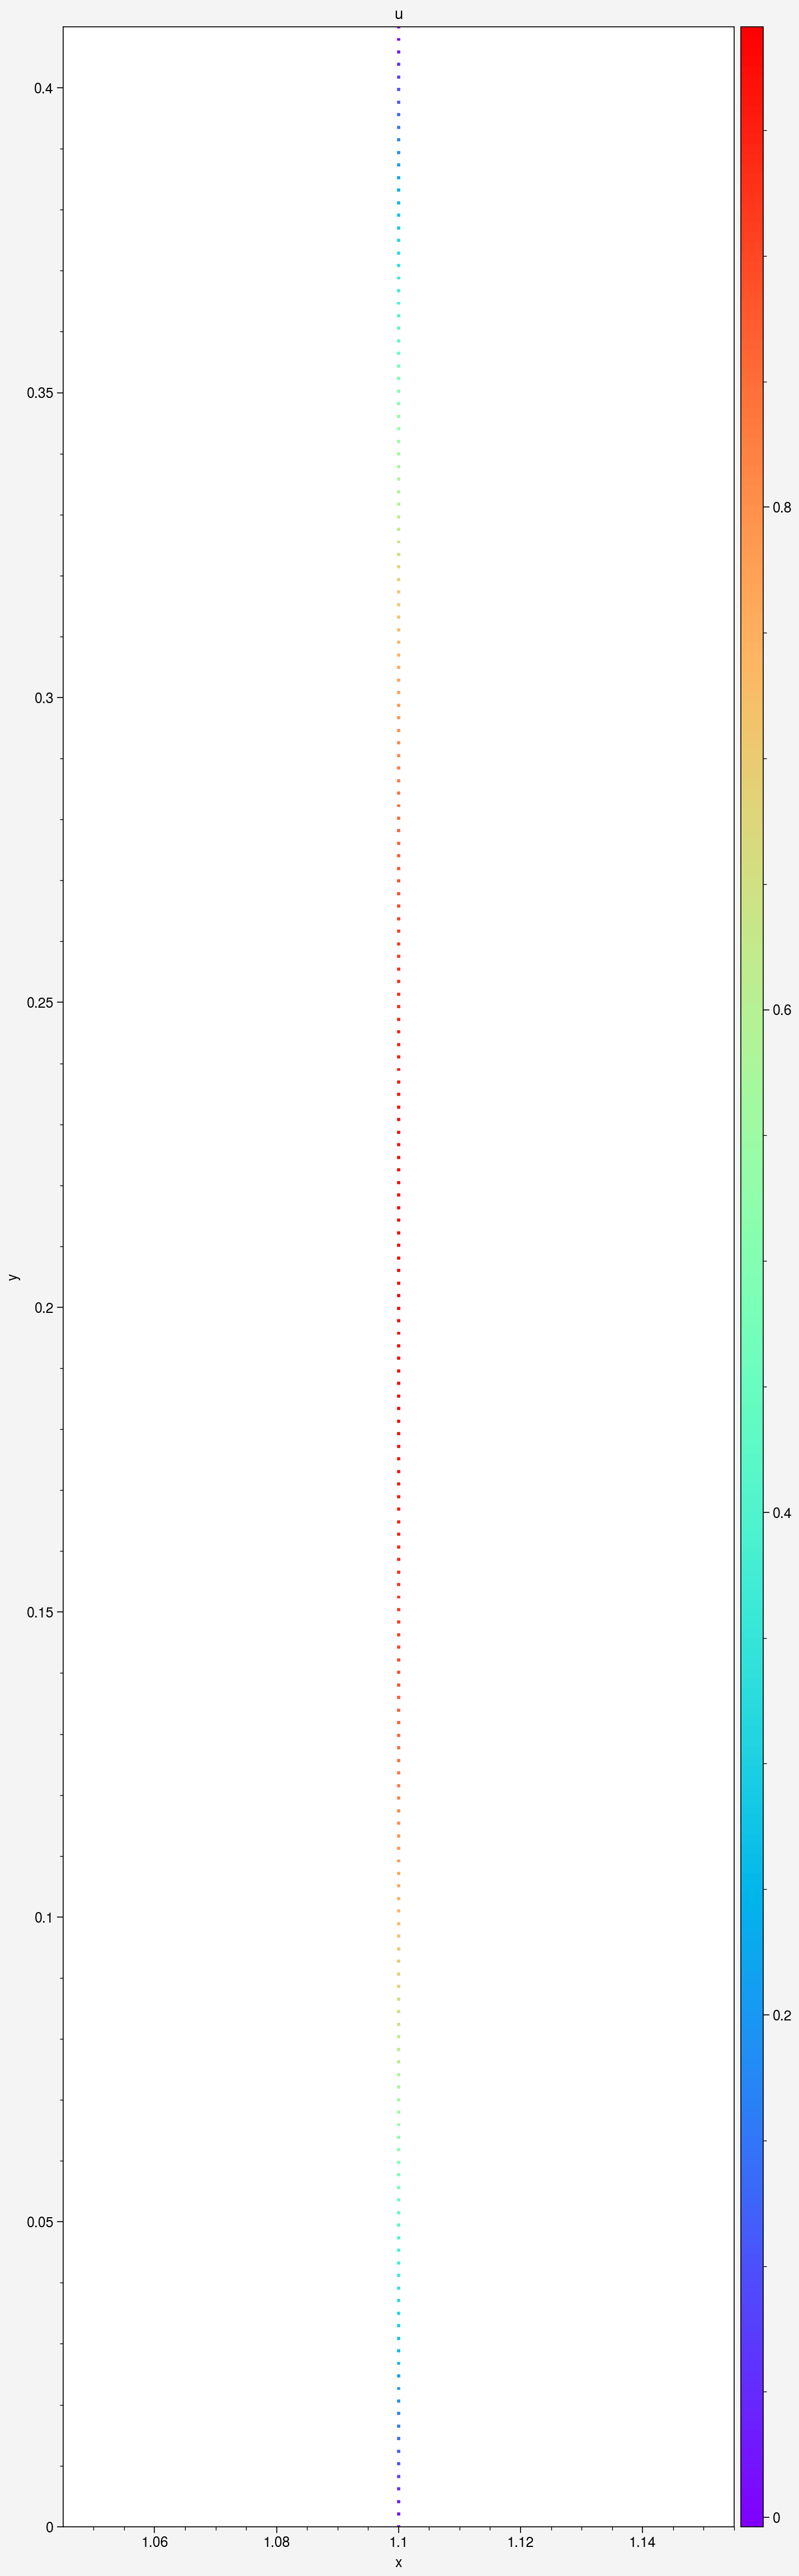

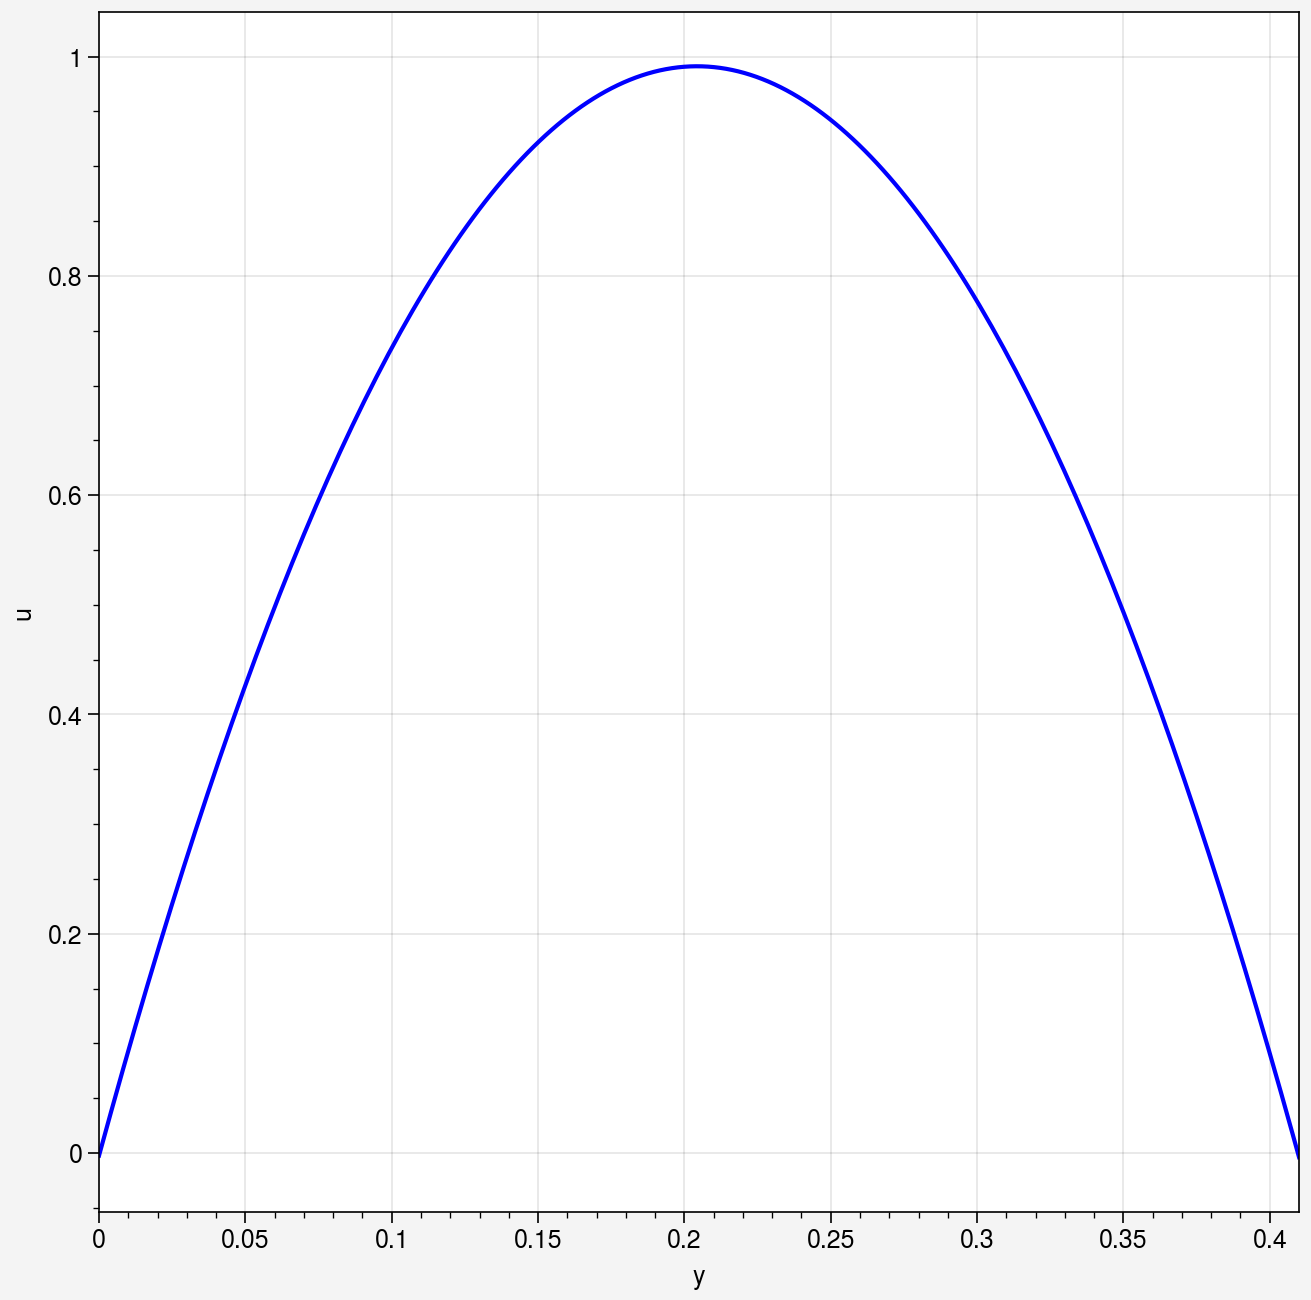

In [17]:
_ = bound_visual.plot_color('u', cmap = 'rainbow')
_ = bound_visual.plot(x_axis = 'y', y_axis='u')

## 4.3 Visualize Neural Network data

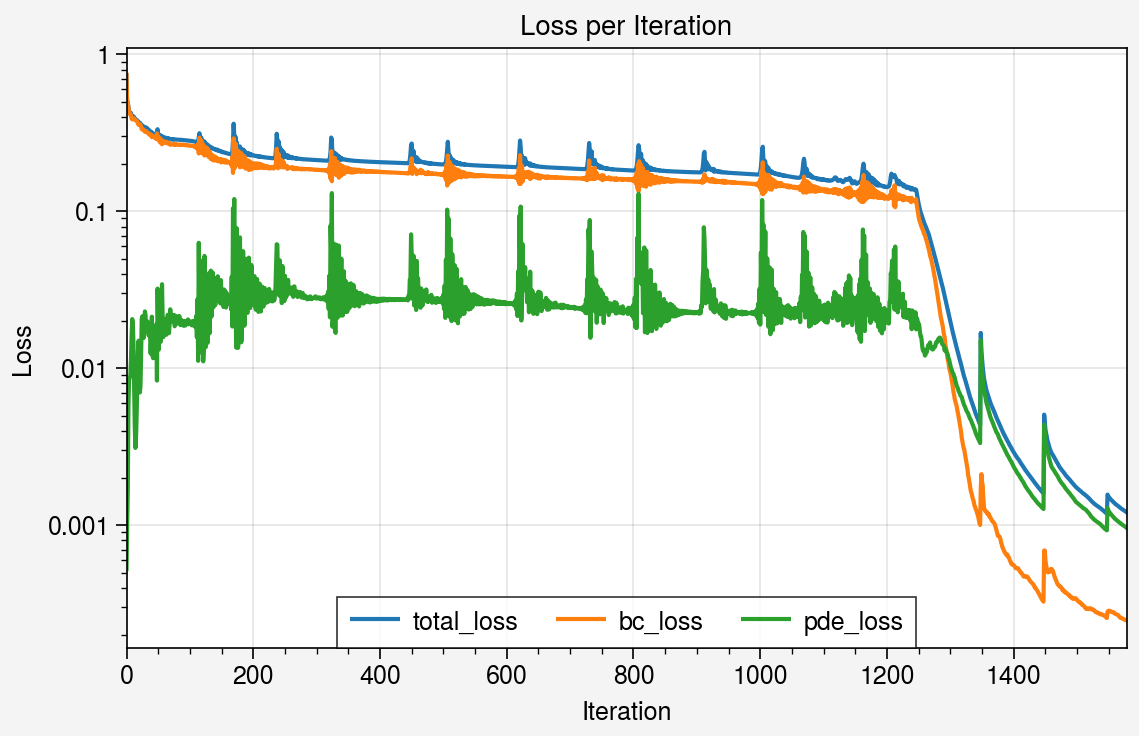

In [19]:
_ = bound_visual.plot_loss_curve(log_scale=True)

### 4.4 Export data

In [20]:
# store the x,y,velocity_magnitude data
x_data = bound_visual.data_dict['x']
y_data = bound_visual.data_dict['y']
u_data = bound_visual.data_dict['u']

#save as txt file
import numpy as np
array = np.column_stack((x_data, y_data, u_data))
np.savetxt('outlet_velocity.txt', array)